In [1]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import PandasTools
from rdkit import DataStructs
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import PredefinedSplit
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import joblib
import warnings
warnings.filterwarnings("ignore")

In [2]:
def error(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    return mse, mae, r2, mape

In [3]:
df = pd.read_csv("DB for chromophore_Sci_Data_rev02.csv")
df = df[df['Solvent'] != 'gas'].reset_index(drop=True)

In [4]:
df['Chromophore_mol'] = df['Chromophore'].apply(lambda x: Chem.MolFromSmiles(x)) 
df['Solvent_mol'] = df['Solvent'].apply(lambda x: Chem.MolFromSmiles(x))

In [5]:
df_emi = df.dropna(subset = 'Emission max (nm)')

In [6]:
ds = df_emi[['Chromophore_mol', 'Solvent_mol','Emission max (nm)']]

### Train / Validation / Test split

In [7]:
col = ds.columns
train_ratio = 0.70
validation_ratio = 0.15
test_ratio = 0.15

dataX = ds[col[0:-1]]
dataY = ds[col[-1]]
x_train, x_test, y_train, y_test = train_test_split(dataX, dataY, test_size= 1 - train_ratio,random_state=0)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio),random_state=0) 

In [8]:
y_train_val = pd.concat([y_train,y_val])
split_index = [-1 if x in y_train.index else 0 for x in y_train_val.index]
pds = PredefinedSplit(test_fold = split_index)

In [9]:
def extracting(size, df):
    start = time.time()
    df['Chromophore_mfp_{0}'.format(size)] = df['Chromophore_mol'].apply(lambda x: np.array(Chem.rdMolDescriptors.GetMorganFingerprintAsBitVect(x, radius=2, nBits = size)))
    df['Solvent_mfp_{0}'.format(int(size/2))] = df['Solvent_mol'].apply(lambda x: np.array(Chem.rdMolDescriptors.GetMorganFingerprintAsBitVect(x, radius=2, nBits = int(size / 2))))
    end  = time.time()
    t = end - start
    mfp = pd.DataFrame(df['Chromophore_mfp_{0}'.format(size)])
    mfp_exploded = mfp['Chromophore_mfp_{0}'.format(size)].apply(pd.Series)
    mfp_exploded.columns = [f'chromophore_mfp_{size}_column_{i}' for i in range(mfp_exploded.shape[1])]
    s_mfp = pd.DataFrame(df['Solvent_mfp_{0}'.format(int(size/2))])
    s_mfp_exploded = s_mfp['Solvent_mfp_{0}'.format(int(size/2))].apply(pd.Series)
    s_mfp_exploded.columns = [f'solvent_mfp_column_{int(size/2)}_{i}' for i in range(s_mfp_exploded.shape[1])]
    dfm = pd.concat([mfp_exploded,s_mfp_exploded], axis = 1)
    return t, dfm

In [10]:
extract_time_32, data_32 = extracting(32, ds)
extract_time_64, data_64 = extracting(64, ds)
extract_time_128, data_128 = extracting(128, ds)
extract_time_256, data_256 = extracting(256, ds)
extract_time_512, data_512 = extracting(512, ds)
extract_time_1024, data_1024 = extracting(1024, ds)

In [49]:
x_train_32, x_val_32, x_test_32 = data_32.loc[x_train.index],data_32.loc[x_val.index],data_32.loc[x_test.index]
x_train_val_32 = pd.concat([x_train_32,x_val_32])

x_train_64, x_val_64, x_test_64 = data_64.loc[x_train.index],data_64.loc[x_val.index],data_64.loc[x_test.index]
x_train_val_64 = pd.concat([x_train_64,x_val_64])

x_train_128, x_val_128, x_test_128 = data_128.loc[x_train.index],data_128.loc[x_val.index],data_128.loc[x_test.index]
x_train_val_128 = pd.concat([x_train_128,x_val_128])

x_train_256, x_val_256, x_test_256 = data_256.loc[x_train.index],data_256.loc[x_val.index],data_256.loc[x_test.index]
x_train_val_256 = pd.concat([x_train_256,x_val_256])

x_train_512, x_val_512, x_test_512 = data_512.loc[x_train.index],data_512.loc[x_val.index],data_512.loc[x_test.index]
x_train_val_512 = pd.concat([x_train_512,x_val_512])

x_train_1024, x_val_1024, x_test_1024 = data_1024.loc[x_train.index],data_1024.loc[x_val.index],data_1024.loc[x_test.index]
x_train_val_1024 = pd.concat([x_train_1024,x_val_1024])

In [12]:
start = time.time()
knn_32 = Pipeline([('scaler',StandardScaler()), 
                  ('model',KNeighborsRegressor(weights='distance', p = 1, n_neighbors= 5, n_jobs=None))])
knn_32.fit(x_train_32,y_train)
end = time.time()
fit_time_32 = end - start
print(fit_time_32)

start = time.time()
y_test_knn_32  = knn_32.predict(x_test_32)
end = time.time()
pred_time_32 = end - start
print(pred_time_32)

start = time.time()
y_train_knn_32 = knn_32.predict(x_train_32)
end = time.time()
pred_time_32_tr = end - start
print(pred_time_32_tr)

0.05991959571838379


  File "C:\Users\aisan\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


0.7934672832489014
1.7260870933532715


In [13]:
knn_mse_32, knn_mae_32, knn_r2_32, knn_mape_32 = error(y_test, y_test_knn_32)
knn_mse_tr_32, knn_mae_tr_32, knn_r2_tr_32, knn_mape_tr_32 = error(y_train, y_train_knn_32)

In [65]:
def check(test_r2, test_pred_time, test_extract_time, number):
    if test_r2 > 0.8 and test_pred_time + test_extract_time < 0.01:
        print('Testing {0} passed succesfully'.format(number))
    else:
        print('Testing {0} failed'.format(number))
    print('R2 score =', round(test_r2,2))
    print('Average execution time =', round(test_pred_time + test_extract_time, 5))

In [24]:
start = time.time()
knn_64 = Pipeline([('scaler',StandardScaler()), 
                  ('model',KNeighborsRegressor(weights='distance', p = 1, n_neighbors= 5, n_jobs=None))])
knn_64.fit(x_train_64,y_train)
end = time.time()
fit_time_64 = end - start
print(fit_time_64)

start = time.time()
y_test_knn_64  = knn_64.predict(x_test_64)
end = time.time()
pred_time_64 = end - start
print(pred_time_64)

start = time.time()
y_train_knn_64 = knn_64.predict(x_train_64)
end = time.time()
pred_time_64_tr = end - start
print(pred_time_64_tr)

0.06607198715209961
0.8135025501251221
3.276155471801758


In [25]:
knn_mse_64, knn_mae_64, knn_r2_64, knn_mape_64 = error(y_test, y_test_knn_64)
knn_mse_tr_64, knn_mae_tr_64, knn_r2_tr_64, knn_mape_tr_64 = error(y_train, y_train_knn_64)

In [27]:
start = time.time()
knn_128 = Pipeline([('scaler',StandardScaler()), 
                  ('model',KNeighborsRegressor(weights='distance', p = 1, n_neighbors= 5, n_jobs=None))])
knn_128.fit(x_train_128,y_train)
end = time.time()
fit_time_128 = end - start
print(fit_time_128)

start = time.time()
y_test_knn_128  = knn_128.predict(x_test_128)
end = time.time()
pred_time_128 = end - start
print(pred_time_128)

start = time.time()
y_train_knn_128 = knn_128.predict(x_train_128)
end = time.time()
pred_time_128_tr = end - start
print(pred_time_128_tr)

0.10890769958496094
1.5721592903137207
6.6436450481414795


In [28]:
knn_mse_128, knn_mae_128, knn_r2_128, knn_mape_128 = error(y_test, y_test_knn_128)
knn_mse_tr_128, knn_mae_tr_128, knn_r2_tr_128, knn_mape_tr_128 = error(y_train, y_train_knn_128)

In [30]:
start = time.time()
knn_256 = Pipeline([('scaler',StandardScaler()), 
                  ('model',KNeighborsRegressor(weights='distance', p = 1, n_neighbors= 5,n_jobs = None))])
knn_256.fit(x_train_256,y_train)
end = time.time()
fit_time_256 = end - start
print(fit_time_256)

start = time.time()
y_test_knn_256  = knn_256.predict(x_test_256)
end = time.time()
pred_time_256 = end - start
print(pred_time_256)

start = time.time()
y_train_knn_256 = knn_256.predict(x_train_256)
end = time.time()
pred_time_256_tr = end - start
print(pred_time_256_tr)

0.22594237327575684
3.5549817085266113
12.999297618865967


In [31]:
knn_mse_256, knn_mae_256, knn_r2_256, knn_mape_256 = error(y_test, y_test_knn_256)
knn_mse_tr_256, knn_mae_tr_256, knn_r2_tr_256, knn_mape_tr_256 = error(y_train, y_train_knn_256)

Testing {0} passed succesfully
R2 score = 0.85
Average execution time = 0.00189


In [33]:
start = time.time()
knn_512 = Pipeline([('scaler',StandardScaler()), 
                  ('model',KNeighborsRegressor(weights='distance', p = 1, n_neighbors= 5,n_jobs = None))])
knn_512.fit(x_train_512,y_train)
end = time.time()
fit_time_512 = end - start
print(fit_time_512)
start = time.time()
y_test_knn_512  = knn_512.predict(x_test_512)
end = time.time()
pred_time_512 = end - start
print(pred_time_512)

start = time.time()
y_train_knn_512 = knn_512.predict(x_train_512)
end = time.time()
pred_time_512_tr = end - start
print(pred_time_512_tr)

0.43001604080200195
10.032513618469238
32.82618546485901


In [34]:
knn_mse_512, knn_mae_512, knn_r2_512, knn_mape_512 = error(y_test, y_test_knn_512)
knn_mse_tr_512, knn_mae_tr_512, knn_r2_tr_512, knn_mape_tr_512 = error(y_train, y_train_knn_512)

In [50]:
start = time.time()
knn_1024 = Pipeline([('scaler',StandardScaler()), 
                  ('model',KNeighborsRegressor(weights='distance', p = 1, n_neighbors= 5,n_jobs = None))])
knn_1024.fit(x_train_1024,y_train)
end = time.time()
fit_time_1024 = end - start
print(fit_time_1024)
start = time.time()
y_test_knn_1024  = knn_1024.predict(x_test_1024)
end = time.time()
pred_time_1024 = end - start
print(pred_time_1024)

start = time.time()
y_train_knn_1024 = knn_1024.predict(x_train_1024)
end = time.time()
pred_time_1024_tr = end - start
print(pred_time_1024_tr)

1.0681278705596924
24.189274311065674
91.95559787750244


In [51]:
knn_mse_1024, knn_mae_1024, knn_r2_1024, knn_mape_1024 = error(y_test, y_test_knn_1024)
knn_mse_tr_1024, knn_mae_tr_1024, knn_r2_tr_1024, knn_mape_tr_1024 = error(y_train, y_train_knn_1024)

In [66]:
check(knn_r2_32, pred_time_32 / len(y_test), extract_time_32 / len(ds), '1')
print('-----')
check(knn_r2_64, pred_time_64 / len(y_test), extract_time_64 / len(ds), '2')
print('-----')
check(knn_r2_128, pred_time_128 / len(y_test), extract_time_128 / len(ds), '3')
print('-----')
check(knn_r2_256, pred_time_256 / len(y_test), extract_time_256 / len(ds), '4')
print('-----')
check(knn_r2_512, pred_time_512 / len(y_test), extract_time_512 / len(ds), '5')
print('-----')
check(knn_r2_1024, pred_time_1024 / len(y_test), extract_time_1024 / len(ds), '6')
print('-----')

Testing 1 failed
R2 score = 0.6
Average execution time = 0.00069
-----
Testing 2 passed succesfully
R2 score = 0.81
Average execution time = 0.00071
-----
Testing 3 passed succesfully
R2 score = 0.84
Average execution time = 0.00109
-----
Testing 4 passed succesfully
R2 score = 0.85
Average execution time = 0.00189
-----
Testing 5 passed succesfully
R2 score = 0.84
Average execution time = 0.0046
-----
Testing 6 failed
R2 score = 0.84
Average execution time = 0.01031
-----


In [54]:
r2  = knn_r2_32, knn_r2_64, knn_r2_128, knn_r2_256, knn_r2_512, knn_r2_1024
mse = knn_mse_32, knn_mse_64, knn_mse_128, knn_mse_256, knn_mse_512, knn_mse_1024
mae = knn_mae_32, knn_mae_64, knn_mae_128, knn_mae_256, knn_mae_512, knn_mae_1024
mape = knn_mape_32, knn_mape_64, knn_mape_128, knn_mape_256, knn_mape_512, knn_mape_1024
size = [32,64,128,256, 512, 1024]
pred_time = pred_time_32, pred_time_64, pred_time_128, pred_time_256, pred_time_512, pred_time_1024
pred_time_tr = pred_time_32_tr, pred_time_64_tr, pred_time_128_tr, pred_time_256_tr, pred_time_512_tr, pred_time_1024_tr
fit_time = fit_time_32, fit_time_64,fit_time_128, fit_time_256, fit_time_512, fit_time_1024
extract_time = extract_time_32, extract_time_64,extract_time_128, extract_time_256, extract_time_512, extract_time_1024

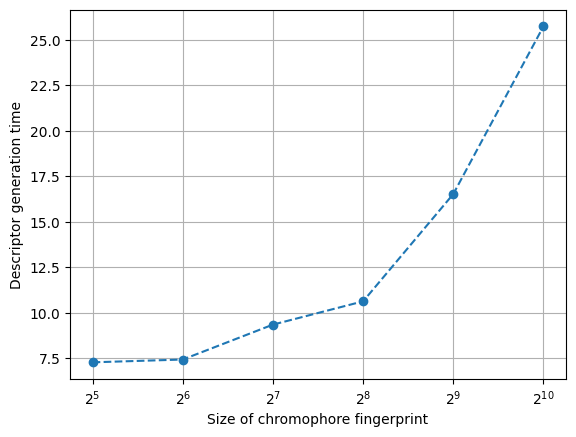

In [70]:
plt.plot(size,extract_time, linestyle='dashed',marker ='o')
plt.xscale('log', base = 2)
plt.xlabel('Size of chromophore fingerprint')
plt.ylabel('Descriptor generation time')
plt.grid()

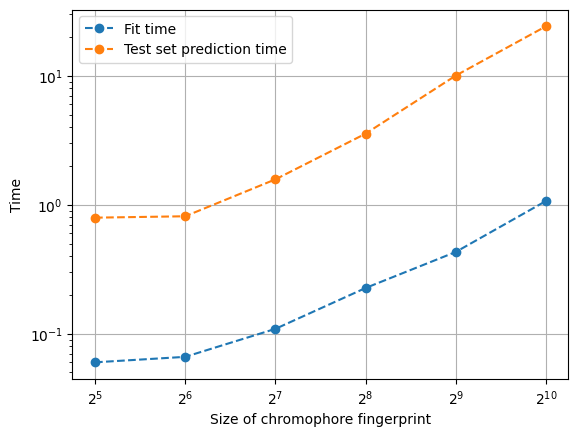

In [56]:
plt.plot(size,fit_time, linestyle='dashed', marker ='o', label = 'Fit time')
plt.plot(size,pred_time, linestyle='dashed', marker ='o', label = 'Test set prediction time')
plt.xscale('log', base = 2)
plt.yscale('log')
plt.xlabel('Size of chromophore fingerprint')
plt.ylabel('Time')
plt.legend(loc='upper left')
plt.grid()

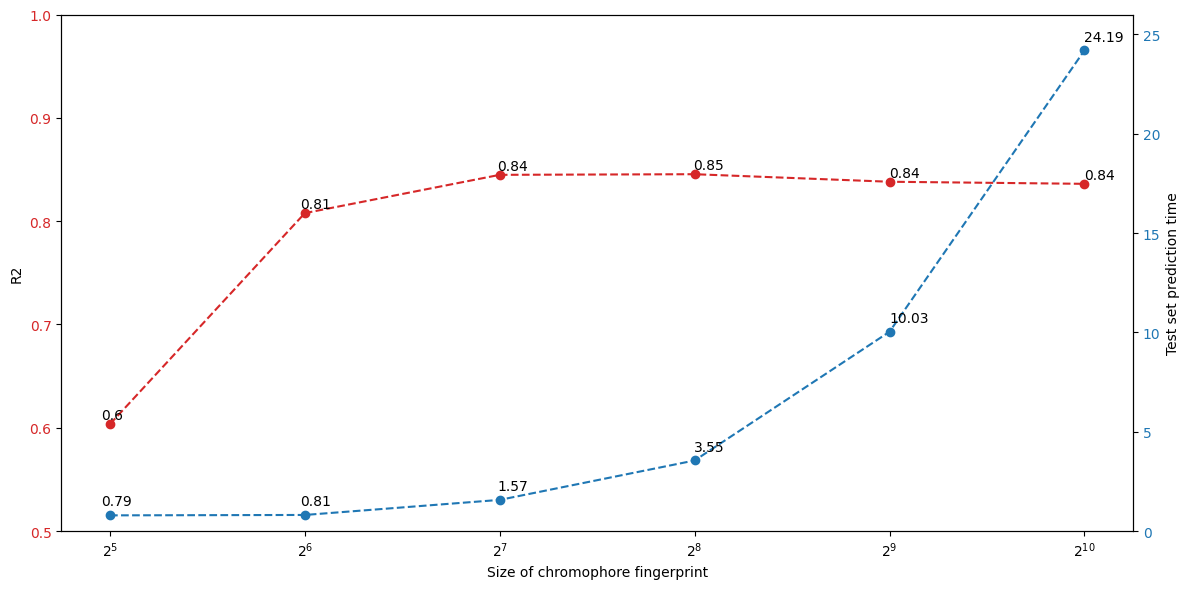

In [67]:
fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:red'
ax1.plot(size,r2, linestyle='dashed', color=color,marker ='o')
ax1.tick_params(axis='y', labelcolor=color)
for index in range(len(size)):
    ax1.text(size[index] - 1, r2[index] + 0.005, round(r2[index],2), size=10)
ax1.set_ylabel('R2')
ax1.set_xlabel('Size of chromophore fingerprint')

ax1.set_ylim([0.5, 1])
ax1.set_xscale('log', base =2)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.plot(size,pred_time, linestyle='dashed', color=color,marker ='o')
for index in range(len(size)):
    ax2.text(size[index] -1 , pred_time[index] + 0.5, round(pred_time[index],2), size=10)
ax2.set_xlabel('Size of chromophore fingerprint')
ax2.set_ylabel('Test set prediction time')
ax2.set_xscale('log', base =2)
ax2.set_ylim([0, 26])
# ax2.set_yscale('log')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

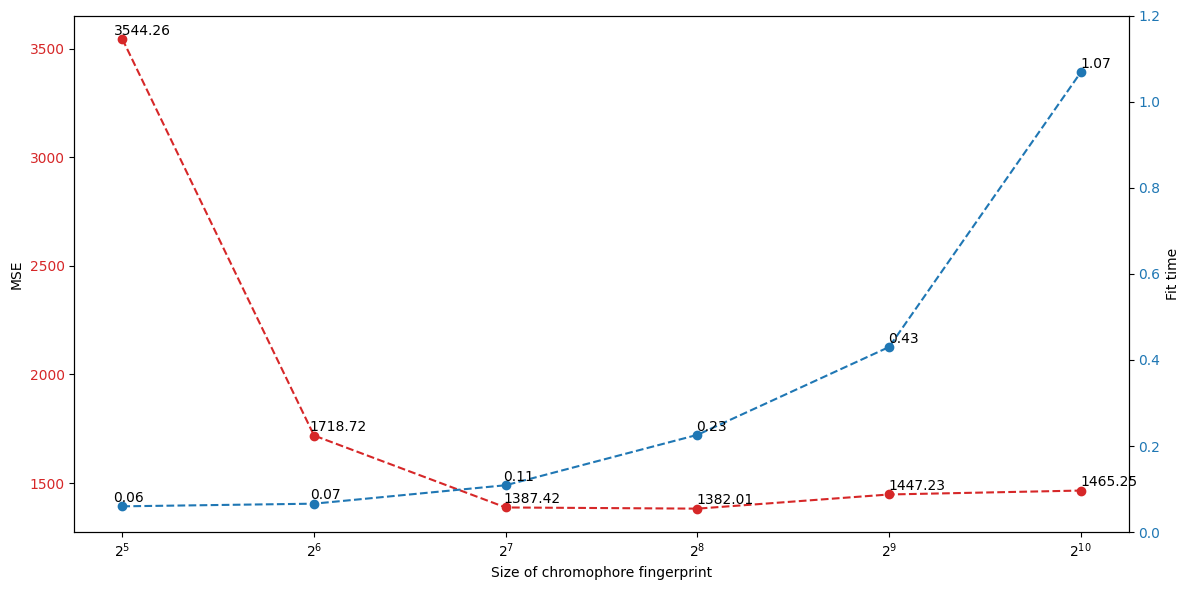

In [60]:
fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:red'
ax1.plot(size,mse, linestyle='dashed', color=color,marker ='o')
ax1.tick_params(axis='y', labelcolor=color)
for index in range(len(size)):
    ax1.text(size[index] -1, mse[index] + 20, round(mse[index],2), size=10)
ax1.set_ylabel('MSE')
ax1.set_xlabel('Size of chromophore fingerprint')

ax1.set_xscale('log', base =2)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.plot(size,fit_time, linestyle='dashed', color=color,marker ='o')
for index in range(len(size)):
    ax2.text(size[index] -1 , fit_time[index] +0.01 , round(fit_time[index],2), size=10)
ax2.set_xlabel('Size of chromophore fingerprint')
ax2.set_ylabel('Fit time')
ax2.set_xscale('log', base =2)
ax2.set_ylim([0, 1.2])
# ax2.set_yscale('log')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

Text(33.347222222222214, 0.5, 'Predicted')

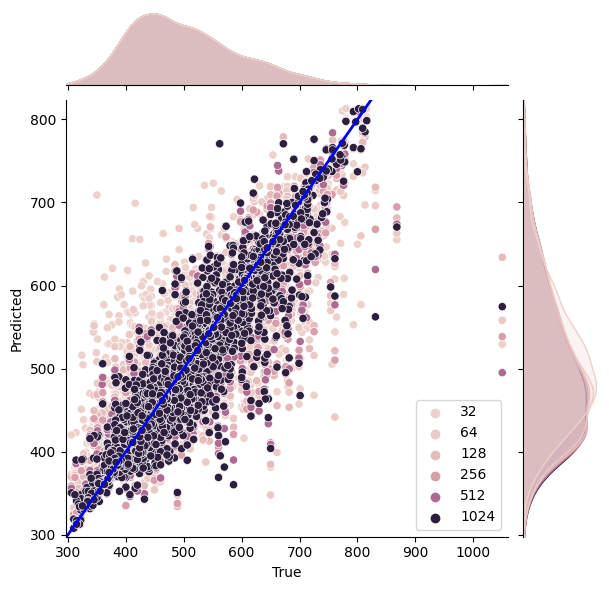

In [68]:
true = y_test
pred = np.transpose([y_test_knn_32, y_test_knn_64, y_test_knn_128,y_test_knn_256, y_test_knn_512, y_test_knn_1024 ])
max_a = max(true) + 10
min_a = min(true) - 10
max_p = np.max(pred) + 10
min_p = np.min(pred) - 10
wide_df = pd.DataFrame(pred , pd.Index(true), size)
plot = sns.jointplot(data=wide_df, xlim = [min_a,max_a], ylim = [min_p,max_p], ratio = 5, height = 6)
plot.ax_joint.plot([min_a ,max_a], [min_a,max_a], 'b-', linewidth = 2)
plot.ax_joint.legend(loc ='lower right')
plot.ax_joint.set_xlabel('True')
plot.ax_joint.set_ylabel('Predicted')